In [ ]:
#!unzip train.csv.zip

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

np.random.seed(42)
random.seed(42)

In [ ]:
data = pd.read_csv('train.csv')
data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
data = np.array(data)
m, n = data.shape
np.random.shuffle(data)

cutoff = int(m * 0.2)
val = data[0:cutoff]
train = data[cutoff:]

y_val = val[:, 0]
x_val = val[:, 1:]

y_train = train[:, 0]
x_train = train[:, 1:]

In [ ]:
x_train = x_train / 255.0
x_val = x_val / 255.0

In [ ]:
def one_hot_encode(y, num_classes):
    one_hot = np.zeros((y.shape[0], num_classes))
    one_hot[np.arange(y.shape[0]), y.astype(int)] = 1
    return one_hot

y_train_one_hot = one_hot_encode(y_train, 10)
y_val_one_hot = one_hot_encode(y_val, 10)

In [ ]:
class MLP:
  def __init__(self, input_size, hidden_size, output_size, learning_rate=0.001):
    self.w1 = np.random.randn(input_size, hidden_size) * 0.01
    self.b1 = np.zeros((1, hidden_size))
    self.w2 = np.random.randn(hidden_size, output_size) * 0.01
    self.b2 = np.zeros((1, output_size))
    self.learning_rate = learning_rate

  def get_weights(self):
    return self.w1, self.b1, self.w2, self.b2

  def relu(self, z):
    return np.maximum(0, z)

  def relu_derivative(self, z):
    return np.where(z > 0, 1, 0)

  def softmax(self, z):
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

  def forward(self, x):
    z1 = np.dot(x, self.w1) + self.b1
    a1 = self.relu(z1)
    z2 = np.dot(a1, self.w2) + self.b2
    a2 = self.softmax(z2)
    return a1, a2

  def compute_loss(self, y_true, y_pred):
    m = y_true.shape[0]
    log_probs = -np.log(y_pred[range(m), y_true])
    loss = np.sum(log_probs) / m
    return loss

  def backward(self, x, y_true, a1, a2):
    m = x.shape[0]
    y_true_encoded = np.zeros_like(a2)
    y_true_encoded[np.arange(m), y_true] = 1

    dz2 = a2 - y_true_encoded
    dw2 = np.dot(a1.T, dz2) / m
    db2 = np.sum(dz2, axis=0, keepdims=True) / m

    dz1 = np.dot(dz2, self.w2.T) * self.relu_derivative(a1)
    dw1 = np.dot(x.T, dz1) / m
    db1 = np.sum(dz1, axis=0, keepdims=True) / m

    return dw1, db1, dw2, db2

  def update_weights(self, dw1, db1, dw2, db2, lambda_reg=0.001):
    self.w1 -= self.learning_rate * (dw1 + lambda_reg * self.w1)
    self.b1 -= self.learning_rate * db1
    self.w2 -= self.learning_rate * (dw2 + lambda_reg * self.w2)
    self.b2 -= self.learning_rate * db2

  def train(self, x_train, y_train, epochs=100, batch_size=64):
    m = x_train.shape[0]
    for epoch in range(epochs):
        perm = np.random.permutation(m)
        x_train = x_train[perm]
        y_train = y_train[perm]

        for i in range(0, m, batch_size):
            x_batch = x_train[i:i+batch_size]
            y_batch = y_train[i:i+batch_size]

            a1, a2 = self.forward(x_batch)
            loss = self.compute_loss(y_batch, a2)
            dw1, db1, dw2, db2 = self.backward(x_batch, y_batch, a1, a2)
            self.update_weights(dw1, db1, dw2, db2)

        print(f'Epoch {epoch+1}, Loss: {loss}')

  def predict(self, x):
    _, a2 = self.forward(x)
    return np.argmax(a2, axis=1)

In [ ]:
def one_hot_encode(y, num_classes):
    one_hot = np.zeros((y.shape[0], num_classes))
    one_hot[np.arange(y.shape[0]), y.astype(int)] = 1
    return one_hot

y_train_one_hot = one_hot_encode(y_train, 10)
y_val_one_hot = one_hot_encode(y_val, 10)

input_size = x_train.shape[1]
hidden_size = 64
output_size = 10

mlp = MLP(input_size, hidden_size, output_size, learning_rate=0.01)
epochs = 100

mlp.train(x_train, y_train, epochs)

y_val_pred = mlp.predict(x_val)

accuracy = np.mean(y_val_pred == y_val)
print(f'Validation Accuracy: {accuracy * 100:.2f}%')


Epoch 1, Loss: 2.126372329469831
Epoch 2, Loss: 0.9914965675128624
Epoch 3, Loss: 0.6974935430162084
Epoch 4, Loss: 0.593314557333167
Epoch 5, Loss: 0.49599697101836376
Epoch 6, Loss: 0.7262614576926157
Epoch 7, Loss: 0.4999658812713039
Epoch 8, Loss: 0.30866286468537263
Epoch 9, Loss: 0.29424743369872797
Epoch 10, Loss: 0.37994045372151597
Epoch 11, Loss: 0.3359185836890659
Epoch 12, Loss: 0.44926888665364906
Epoch 13, Loss: 0.44012110401703164
Epoch 14, Loss: 0.47034561472961156
Epoch 15, Loss: 0.2321156377710406
Epoch 16, Loss: 0.37475164483882983
Epoch 17, Loss: 0.2741804824270567
Epoch 18, Loss: 0.2567356438088474
Epoch 19, Loss: 0.22281919832904273
Epoch 20, Loss: 0.26209448056150497
Epoch 21, Loss: 0.28033544583927605
Epoch 22, Loss: 0.17977304173778177
Epoch 23, Loss: 0.48706108893734135
Epoch 24, Loss: 0.2890195505820363
Epoch 25, Loss: 0.38478422080818026
Epoch 26, Loss: 0.24994020345331833
Epoch 27, Loss: 0.1582157861099452
Epoch 28, Loss: 0.09866790268268319
Epoch 29, Loss:

Prediction: 6
Actual Label: 6


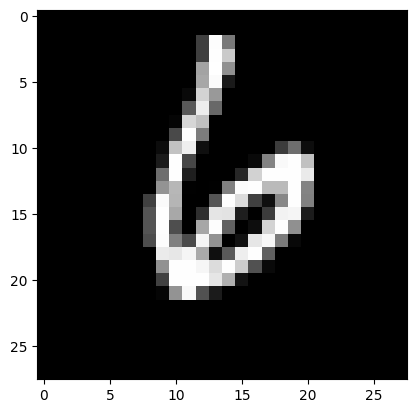

Prediction: 5
Actual Label: 5


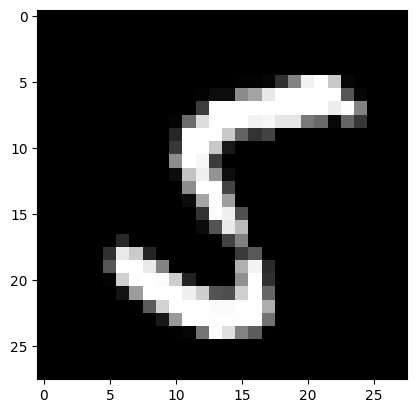

Prediction: 3
Actual Label: 3


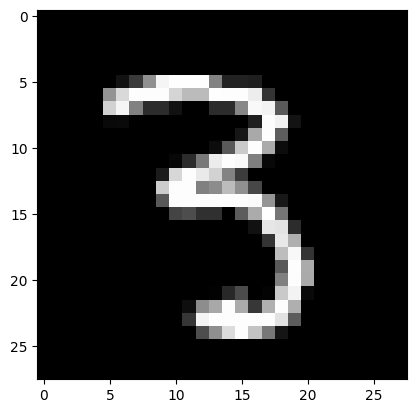

Prediction: 4
Actual Label: 4


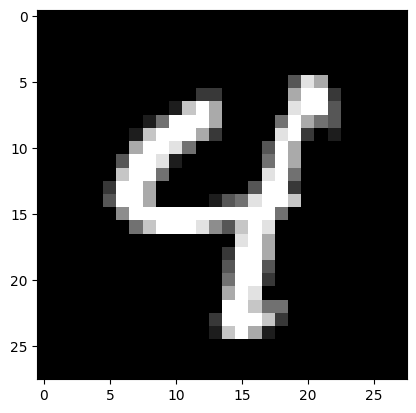

Prediction: 7
Actual Label: 7


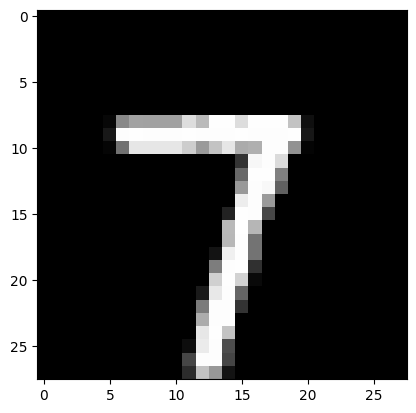

Prediction: 8
Actual Label: 8


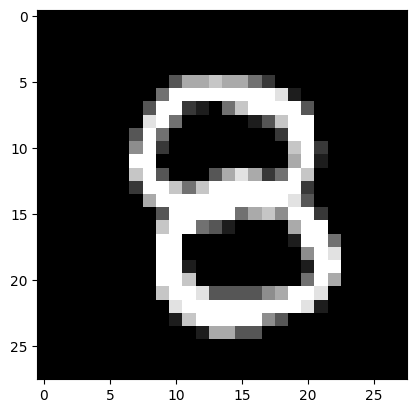

Prediction: 6
Actual Label: 6


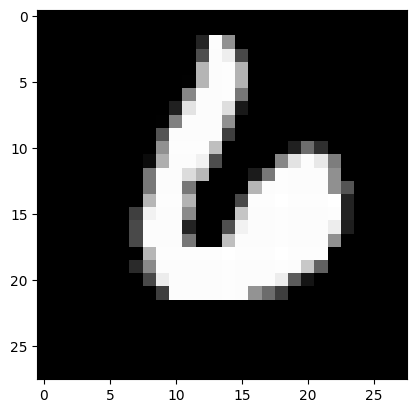

Prediction: 7
Actual Label: 7


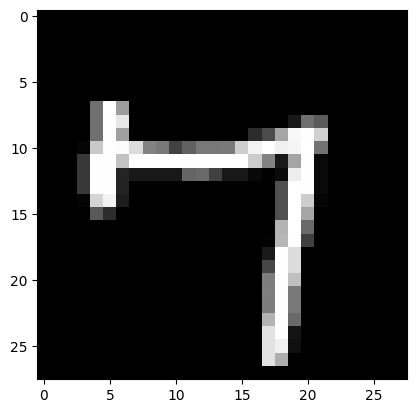

Prediction: 0
Actual Label: 0


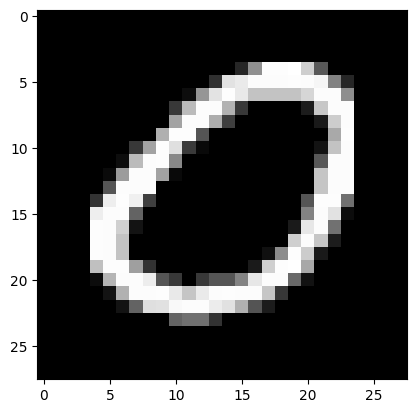

Prediction: 9
Actual Label: 9


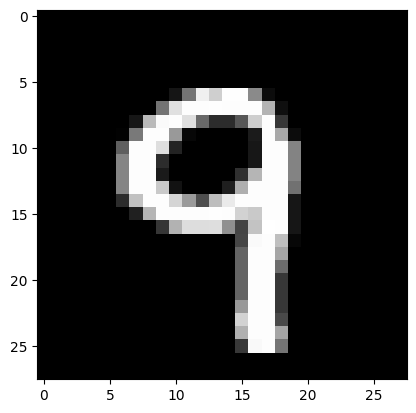

In [ ]:
def make_prediction(X, w1, b1, w2, b2):
    z1 = np.dot(X, w1) + b1
    a1 = np.maximum(0, z1)
    z2 = np.dot(a1, w2) + b2
    a2 = np.exp(z2) / np.sum(np.exp(z2), axis=1, keepdims=True)
    return np.argmax(a2, axis=1)


def test_prediction(index, x_train, y_train, w1, b1, w2, b2):
    current_image = x_train[index].reshape(1, -1)
    prediction = make_prediction(current_image, w1, b1, w2, b2)
    label = y_train[index]

    print(f"Prediction: {prediction[0]}")
    print(f"Actual Label: {label}")

    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()


w1, b1, w2, b2 = mlp.get_weights()

for i in range(10):
  test_prediction(i, x_train, y_train, w1, b1, w2, b2)



Number of misclassified examples: 366
Predicted Label: 8
Actual Label: 9


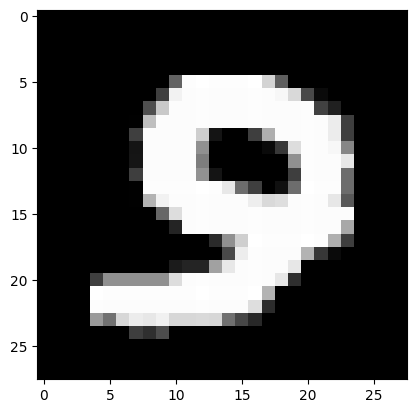

Predicted Label: 8
Actual Label: 9


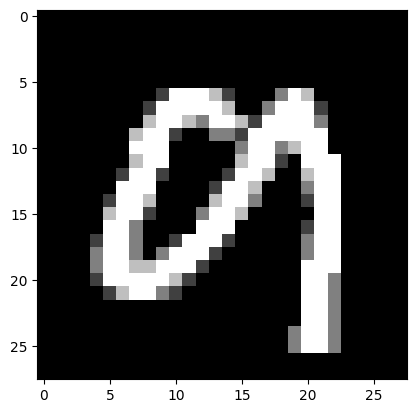

Predicted Label: 5
Actual Label: 8


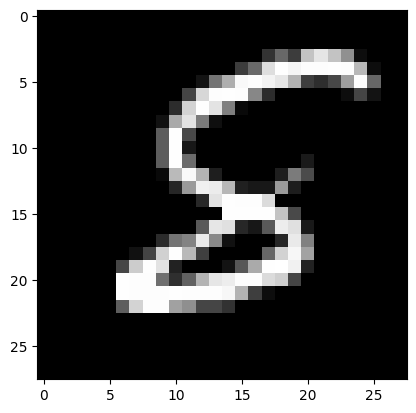

Predicted Label: 7
Actual Label: 9


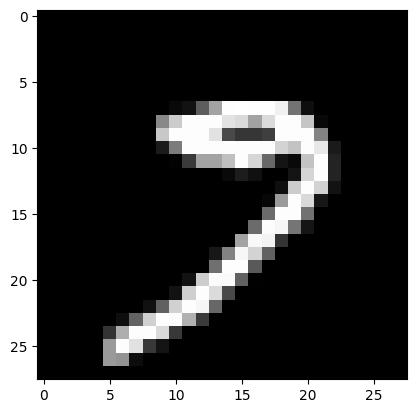

Predicted Label: 4
Actual Label: 7


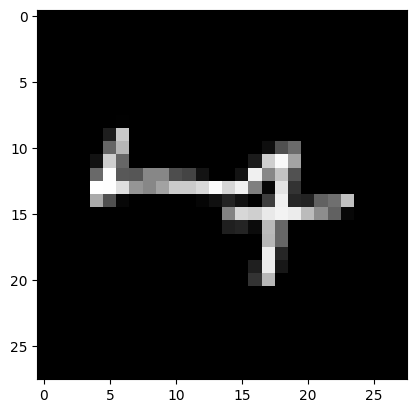

Predicted Label: 9
Actual Label: 5


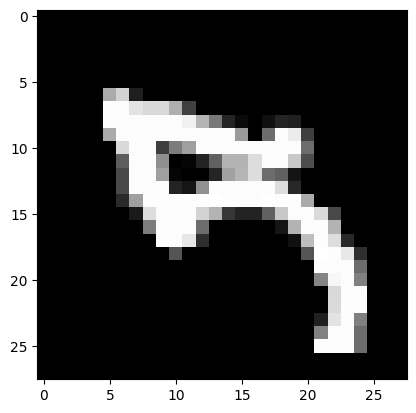

Predicted Label: 9
Actual Label: 7


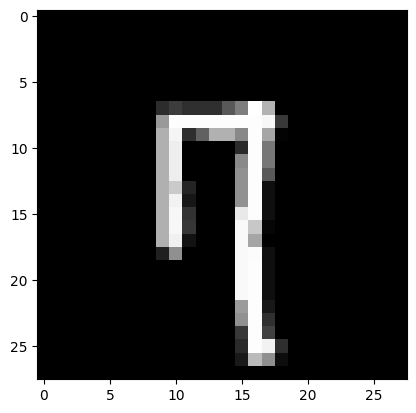

Predicted Label: 3
Actual Label: 7


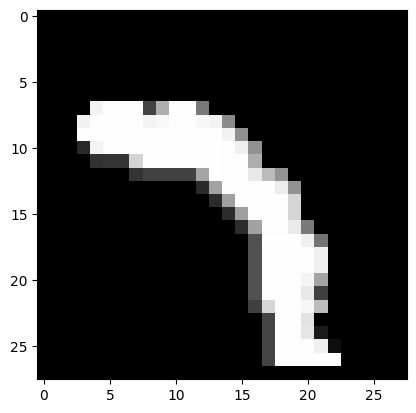

Predicted Label: 8
Actual Label: 2


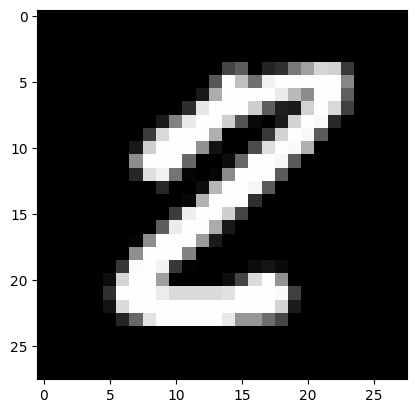

Predicted Label: 8
Actual Label: 1


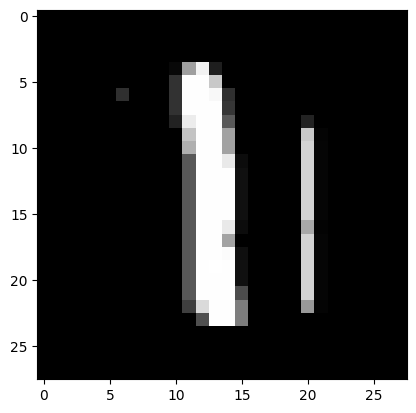

Predicted Label: 4
Actual Label: 7


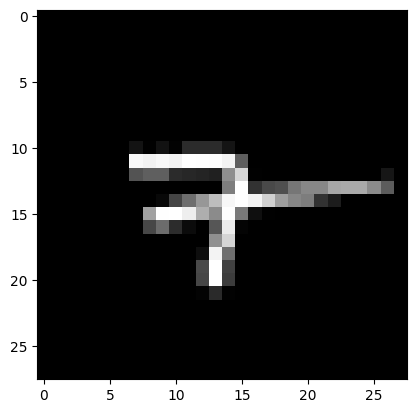

Predicted Label: 5
Actual Label: 9


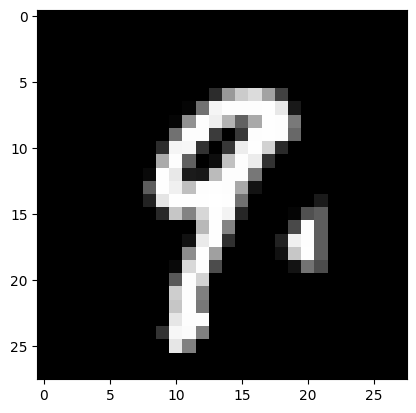

Predicted Label: 3
Actual Label: 9


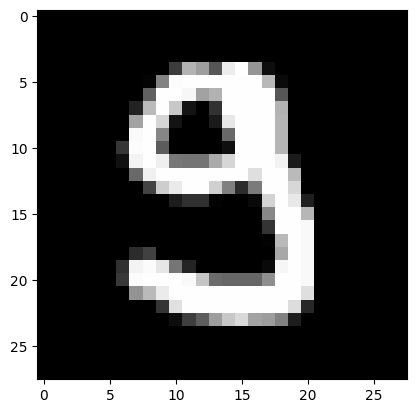

Predicted Label: 2
Actual Label: 9


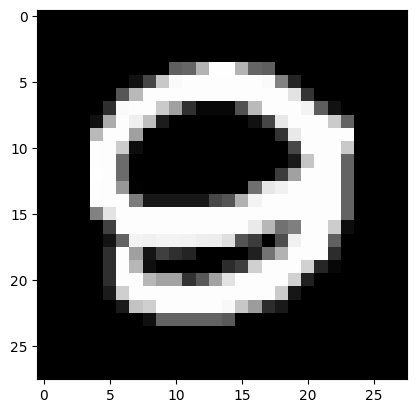

Predicted Label: 7
Actual Label: 3


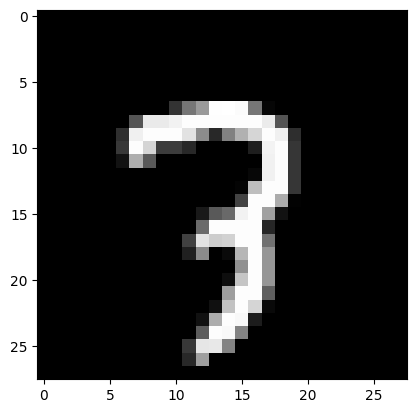

In [ ]:
def find_misclassified(x_data, y_true, w1, b1, w2, b2):
    # Make predictions for the entire dataset
    predictions = make_prediction(x_data, w1, b1, w2, b2)

    # Find misclassified examples
    misclassified_indices = np.where(predictions != y_true)[0]

    print(f"Number of misclassified examples: {len(misclassified_indices)}")

    return misclassified_indices, predictions

def show_misclassified_example(index, x_data, y_true, predictions):
    # Get the misclassified image
    current_image = x_data[index].reshape(1, -1)
    predicted_label = predictions[index]
    actual_label = y_true[index]

    # Display the image, predicted label, and actual label
    print(f"Predicted Label: {predicted_label}")
    print(f"Actual Label: {actual_label}")

    current_image = current_image.reshape((28, 28)) * 255  # Rescale for visualization
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()


# After training the model
w1, b1, w2, b2 = mlp.get_weights()

# Find misclassified examples in the validation set
misclassified_indices, predictions = find_misclassified(x_val, y_val, w1, b1, w2, b2)

# Visualize the first misclassified example
j = 0
for i in misclassified_indices:
    show_misclassified_example(i, x_val, y_val, predictions)
    j += 1
    if j == 15:
      break